# Рекомендация тарифов

**Описание проекта**

Оператор мобильной связи «Мегалайн» выяснил: многие клиенты пользуются архивными тарифами. Они хотят построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».

В нашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы. Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных уже сделана.

**Описание данных**

Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Известно:

* `сalls` — количество звонков,
* `minutes` — суммарная длительность звонков в минутах,
* `messages` — количество sms-сообщений,
* `mb_used` — израсходованный интернет-трафик в Мб,
* `is_ultra` — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

## Подготовка и общий анализ

### Импорт библиотек

In [1]:
# pandas
import pandas as pd

# numpy
import numpy as np

# pyplot
import matplotlib.pyplot as plt

# sklearn для классификации
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# display
from IPython.display import display
from IPython.core.display import HTML

In [2]:
# центровка изображений
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""");

### Импорт и быстрый обзор данных

In [3]:
try:  # локальный импорт данных
    df = pd.read_csv('./datasets/users_behavior.csv')

except:  # локальный не сработал => импорт с сервера Практикума
    df = pd.read_csv('/datasets/users_behavior.csv')

In [4]:
display(df.sample(5))
df.info()

,calls,minutes,messages,mb_used,is_ultra
3180,19.0,165.05,0.0,9607.85,0
708,18.0,109.60,14.0,766.23,0
3208,164.0,1016.98,71.0,17787.52,1
3210,25.0,190.36,0.0,3275.61,0
2065,25.0,171.55,22.0,11191.22,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


### Вывод

В таблице 3214 объектов, у каждого объекта по 5 признаков. Отсутствующих значений нет. Данные уже подготовлены.

Признаки (**features**):
* `calls`
* `minutes`
* `messages`
* `mb_used`

Целевой признак (**target**):
* `is_ultra`

In [5]:
features = df.drop(['is_ultra'], axis=1)
target = df['is_ultra']

## Разбиение данных на выборки

Мы решаем задачу класса "обучение с учителем". "Учитель" ставит вопросы (**features**, признаки) и указывает ответы (**target**, целевой признак).

Целевой признак категориальный, имеет два состояния: тариф «Ультра» — 1, и тариф «Смарт» — 0, таким образом речь идёт о бинарной (двоичной) классификации.

Разделим данные на 3 выборки, согласно рекомендованной формуле 3:1:1.

1. Обучающая выборка – обучающий набор данных и целевой признак, который нужно предсказать по остальным признакам.
    * ***features_train***
    * ***target_train***


2. Валидационная выборка – покажет как ведёт себя модель в полевых условиях.
    * ***features_valid***
    * ***target_valid***
    
    
3. Тестовая выборка – набор данных, на котором мы будем проверять качество обученной модели.
    * ***features_test***
    * ***target_test***

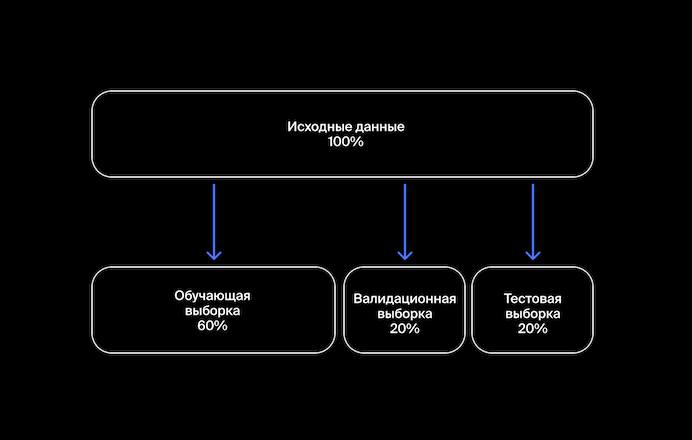

In [6]:
# определяем соотношения
ratio_train = .60
ratio_valid = .20
ratio_test = .20

# выделяем тестовую выборку
features_interim, features_test, target_interim, target_test = train_test_split(
    features, target, test_size=ratio_test, random_state=12345)

# подгоняем размер валидационной выборки
ratio_valid_adjusted = ratio_valid / (1 - ratio_test)

# выделяем обучающую и валидационную выборки
features_train, features_valid, target_train, target_valid = train_test_split(
    features_interim, target_interim, test_size=ratio_valid_adjusted, random_state=12345)

In [7]:
# проверяем результат
print(f"Размер обучающей выборки: {len(features_train), len(target_train)}")
print(f"Размер валидационной выборки: {len(features_valid), len(target_valid)}")
print(f"Размер тестовой выборки: {len(features_test), len(target_test)}")

Размер обучающей выборки: (1928, 1928)
Размер валидационной выборки: (643, 643)
Размер тестовой выборки: (643, 643)


## Исследование моделей

Возьмём три известные нам классификационные модели и сравним точность их работы с помощью метрики **accuracy** – отношения числа правильных ответов к размеру тестовой выборки.

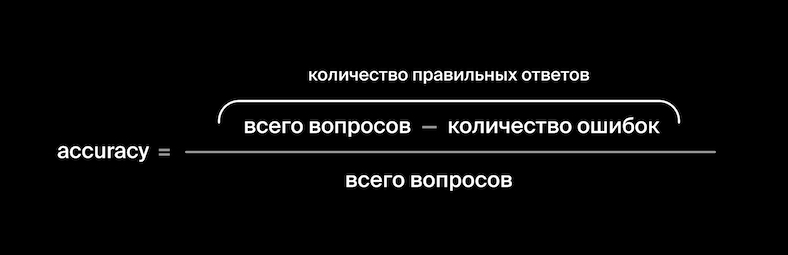

### Decision Tree Classifier

In [8]:
graph = []
best_result = 0
best_depth = 0

for depth in range(1, 11):

    # инициализируем модель
    model_DTC = DecisionTreeClassifier(
        random_state=12345, max_depth=depth)

    # обучим модель на тренировочной выборке
    model_DTC.fit(features_train, target_train)

    # посчитаем качество модели на валидационной выборке
    result = model_DTC.score(features_valid, target_valid)
    
    graph.append([depth, result])

    if result > best_result:
        best_result = result
        best_depth = depth

print(f"Точность модели \033[1mдерева решений\033[0;0m на валидационной выборке: {best_result}\n")
print(f"Максимальная глубина: {best_depth}\n")

Точность модели дерева решений на валидационной выборке: 0.7744945567651633

Максимальная глубина: 7



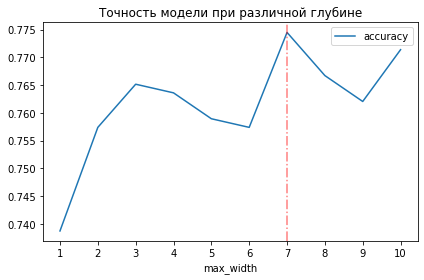

In [9]:
pd.DataFrame(graph, columns=['max_width', 'accuracy']).plot(x='max_width', y='accuracy')

plt.title('Точность модели при различной глубине')
plt.axvline(x=best_depth, color='red', linestyle='-.', alpha=0.5)

plt.xticks(list(range(1, len(graph)+1)))
plt.tight_layout()
plt.show()

Попробуем ту же модель с критерием `entropy`, вместо `gini`.

In [10]:
graph = []
best_result = 0
best_depth = 0

for depth in range(1, 11):

    # инициализируем модель
    model_DTC = DecisionTreeClassifier(
        random_state=12345, max_depth=depth, criterion="entropy")

    # обучим модель на тренировочной выборке
    model_DTC.fit(features_train, target_train)

    # посчитаем качество модели на валидационной выборке
    result = model_DTC.score(features_valid, target_valid)

    graph.append([depth, result])
    
    if result > best_result:
        best_result = result
        best_depth = depth

print(f"Точность модели \033[1mдерева решений\033[0;0m на валидационной выборке: {best_result}\n")
print(f"Максимальная глубина: {best_depth}\n")

Точность модели дерева решений на валидационной выборке: 0.7838258164852255

Максимальная глубина: 9



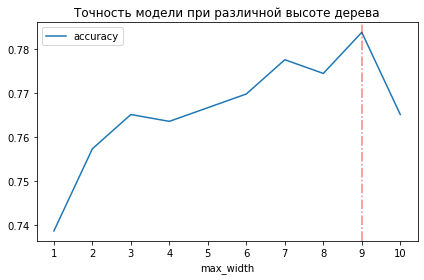

In [11]:
pd.DataFrame(graph, columns=['max_width', 'accuracy']).plot(x='max_width', y='accuracy')

plt.title('Точность модели при различной высоте дерева')
plt.axvline(x=best_depth, color='red', linestyle='-.', alpha=0.5)

plt.xticks(list(range(1, len(graph)+1)))
plt.tight_layout()
plt.show()

Получили результат немного выше, остановимся на этом.

### Random Forest Classifier

In [12]:
best_result = 0
best_est = 0
best_depth = 0

# для экономии времени в est и depth подставлены оптимальные значения
for est in range(36, 37):
    for depth in range(10, 11):

        # инициализируем модель
        model_RFC = RandomForestClassifier(
            random_state=12345, max_depth=depth, n_estimators=est)

        # обучим модель на тренировочной выборке
        model_RFC.fit(features_train, target_train)

        # посчитаем качество модели на валидационной выборке
        result = model_RFC.score(features_valid, target_valid)

        if result > best_result:
            best_result = result
            best_est = est
            best_depth = depth

print(f"Точность модели \033[1mслучайного леса\033[0;0m на валидационной выборке: {best_result}\n")
print(f"Количество деревьев: {best_est}")
print(f"Максимальная глубина: {best_depth}\n")

Точность модели случайного леса на валидационной выборке: 0.7993779160186625

Количество деревьев: 36
Максимальная глубина: 10



Снова попробуем воспроизвести модель с критерием `entropy`, вместо `gini`.

In [13]:
graph = []

best_result = 0
best_est = 0
best_depth = 0

# для экономии времени в est и depth подставлены аналогичные прошлой модели значения
for est in range(36, 37):
    for depth in range(10, 11):

        # инициализируем модель
        model_RFC1 = RandomForestClassifier(
            random_state=12345, max_depth=depth, n_estimators=est, criterion="entropy")

        # обучим модель на тренировочной выборке
        model_RFC1.fit(features_train, target_train)

        # посчитаем качество модели на валидационной выборке
        result = model_RFC1.score(features_valid, target_valid)
        
        graph.append([depth, est, result])

        if result > best_result:
            best_result = result
            best_est = est
            best_depth = depth

print(f"Точность модели \033[1mслучайного леса\033[0;0m на валидационной выборке: {best_result}\n")
print(f"Количество деревьев: {best_est}")
print(f"Максимальная глубина: {best_depth}\n")

Точность модели случайного леса на валидационной выборке: 0.7853810264385692

Количество деревьев: 36
Максимальная глубина: 10



В этот раз критерий `entropy` показал меньшую точность, по сравнению с `gini`.

***Disclaimer: проверка выполнена на полном диапазоне, в гиперпараметрах оставлены значения из прошлой модели для экономия времени.***

### Logistic Regression

In [14]:
# инициализируем модель
model_LR = LogisticRegression(random_state=12345, solver="lbfgs", max_iter=1000)

# обучим модель на тренировочной выборке
model_LR.fit(features_train, target_train)

# посчитаем качество модели на валидационной выборке
result = model_LR.score(features_valid, target_valid)

print(f"Точность модели \033[1mлогистической регрессии\033[0;0m на валидационной выборке: {result}\n")

Точность модели логистической регрессии на валидационной выборке: 0.7262830482115086



### Вывод

На основе исследования трех моделей с изменением фиксированного числа гиперпараметров: **random_state**, **max_depth**, **n_estimators** и **criterion** можно сказать, что наиболее точную оценку показал случайный лес: 0.799.

## Проверка модели на тестовой выборке

In [15]:
result = model_RFC.score(features_test, target_test)

print(f"Точность модели \033[1mслучайного леса\033[0;0m на тестовой выборке: {result}\n")

Точность модели случайного леса на тестовой выборке: 0.8009331259720062



Проверка на тестовой выборке показывает результат немного лучше, чем на валидационной.

## Проверка модели на адекватность (sanity check)

Проверим, что наша модель действительно чему-то научилась. Посмотрим на соотношение классов в тестовом целевом признаке.

In [16]:
print(target_test.value_counts())

0    447
1    196
Name: is_ultra, dtype: int64


Мажоритарный класс имеет значение 0. Посчитаем отношение размера мажоритарного класса к общему числу объектов.

In [17]:
print(f"Количество нулей к общему числу объектов: {target_test.value_counts(normalize=True)[0]}")

Количество нулей к общему числу объектов: 0.6951788491446346


Выполним тот же расчет инструментом **accuracy_score**. Возьмем массив заполненный нулями и рассчитаем какую точность мы получили бы, если бы модель предсказывала исключительно мажоритарный класс.

In [18]:
sanity_check = np.zeros(len(target_test))
accuracy = accuracy_score(target_test, sanity_check)

print(f"Точность при заполнении мажоритарным классом: {accuracy}")

Точность при заполнении мажоритарным классом: 0.6951788491446346


Цифры в двух расчетах сходятся. Точность нашей модели выше расчетного значения. Это значит, что модель делает более осмысленное предсказание, по сравнению с наивным заполнением мажоритарным классом.

## Общий вывод

Мы разобрали игрушечный пример машинного обучения с учителем, решив задачу с бинарной классификацией. В решении мы использовали три модели: решающее дерево, случайный лес и логистическую регрессию. 

Самый точный результат дал случайный лес, это также самая жадная до времени модель, особенно учитывя необходимость поиска и подбора оптимальных гиперпараметров.

Проверка на тестовой выборке подтвердила, что модель выдаёт стабильный результат. Однако следует помнить, что распределение во всех трех выборках стремится к среднему генеральной совокупности, а значит выборки совсем не сильно друг от друга отличаются. В реальной жизни результат может отличаться.

Проверка на адекватность показала, что наша модель выдает точность выше, чем наивное заполнение мажоритарным классом. Это хороший признак.